In [2]:
# %pip install datasets sentence-transformers scikit-learn

In [37]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [3]:
dataset = load_dataset('google-research-datasets/go_emotions', split='train')

c:\Users\Mi\Документы\GitHub\AITH-LLM-basic\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Mi\Документы\GitHub\AITH-LLM-basic\venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mi\.cache\huggingface\hub\datasets--google-research-datasets--go_emotions. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an 

Print some examples

In [4]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [17]:
model_embeddings = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\Mi\Документы\GitHub\AITH-LLM-basic\venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mi\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\Mi\Документы\GitHub\AITH-LLM-basic\venv\Lib\site-packages\transformers\

In [34]:
texts = dataset['text']
embeddings = model_embeddings.encode(texts, show_progress_bar=True)

print(f"Shape of embeddings: {embeddings.shape}")


Batches: 100%|██████████| 1357/1357 [01:58<00:00, 11.44it/s]


Shape of embeddings: (43410, 384)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [36]:
def euclidean_distance(a, b):
    delta = a - b

    return np.sqrt(np.dot(delta, delta))

def cosine_distance(a, b):   
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def mahalanobis_distance(a, b, inv_cov_matrix):
    delta = a - b

    return np.sqrt(np.dot(np.dot(delta.T, inv_cov_matrix), delta))

def correlation_distance(a, b):
    return 1 - np.corrcoef(a, b)[0, 1]

Implement custom K-Means class

In [45]:
class CustomKMeans:
    def __init__(self,
                 n_clusters=3,
                 max_iter=100,
                 distance_metric='euclidean',
                 **kwargs):
        
        if distance_metric not in ['euclidean', 'cosine', 'mahalanobis', 'correlation']:
            raise ValueError('distance_metric must be euclidean, cosine, mahalanobis or correlation!')
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs # inverted covariation matrix for mahalanodis disntace

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            self.labels_ = np.array([self._assign_label(x) for x in X])

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) if len(X[self.labels_ == i]) > 0 else self.centroids[i] for i in range(self.n_clusters)])

            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

    def _assign_label(self, x):
        # assigns each data point to the nearest centroid based on the chosen distance metric.
        # method returns the index of the closest centroid, which represents the cluster assignment (or label) for the given data point x

        if self.distance_metric == 'euclidean':
            distances = np.array([euclidean_distance(x, self.centroids[i]) for i in range(self.n_clusters)])
        elif self.distance_metric == 'cosine':
            distances = np.array([cosine_distance(x, self.centroids[i]) for i in range(self.n_clusters)])
        elif self.distance_metric == 'mahalanobis':
            distances = np.array([mahalanobis_distance(x, self.centroids[i], inv_cov_matrix=self.kwargs["inv_cov_matrix"]) for i in range(self.n_clusters)])
        elif self.distance_metric == 'correlation':
            distances = np.array([correlation_distance(x, self.centroids[i]) for i in range(self.n_clusters)])

        return np.argmin(distances)


## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [84]:
distance_metrics = ['euclidean', 'cosine', 'correlation', 'mahalanobis']

In [85]:
n_clusters = 10

cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

labels_df = pd.DataFrame()

for distance_metric in distance_metrics:
    custom_kmeans = CustomKMeans(n_clusters=10,
                                 max_iter=20,
                                 distance_metric=distance_metric,
                                 inv_cov_matrix=inv_cov_matrix)
    custom_kmeans.fit(embeddings)

    labels = custom_kmeans.labels_

    labels_df[distance_metric] = labels

    print(f"Custom KMeans with {distance_metric} metric labels for the first 10 texts:")
    print(labels[:10])


Custom KMeans with euclidean metric labels for the first 10 texts:
[5 1 1 9 1 6 8 4 3 9]
Custom KMeans with cosine metric labels for the first 10 texts:
[8 1 6 6 8 0 1 4 6 6]
Custom KMeans with correlation metric labels for the first 10 texts:
[1 2 1 9 1 5 3 4 3 9]
Custom KMeans with mahalanobis metric labels for the first 10 texts:
[5 5 8 3 5 7 8 5 2 0]


In [86]:
labels_df.head()

,euclidean,cosine,correlation,mahalanobis
0,5,8,1,5
1,1,1,2,5
2,1,6,1,8
3,9,6,9,3
4,1,8,1,5


## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  
You should get something like this:

<a href="https://ibb.co/nRY9hQf"><img src="https://i.ibb.co/zNBpKPb/output.png" alt="output" border="0"></a>

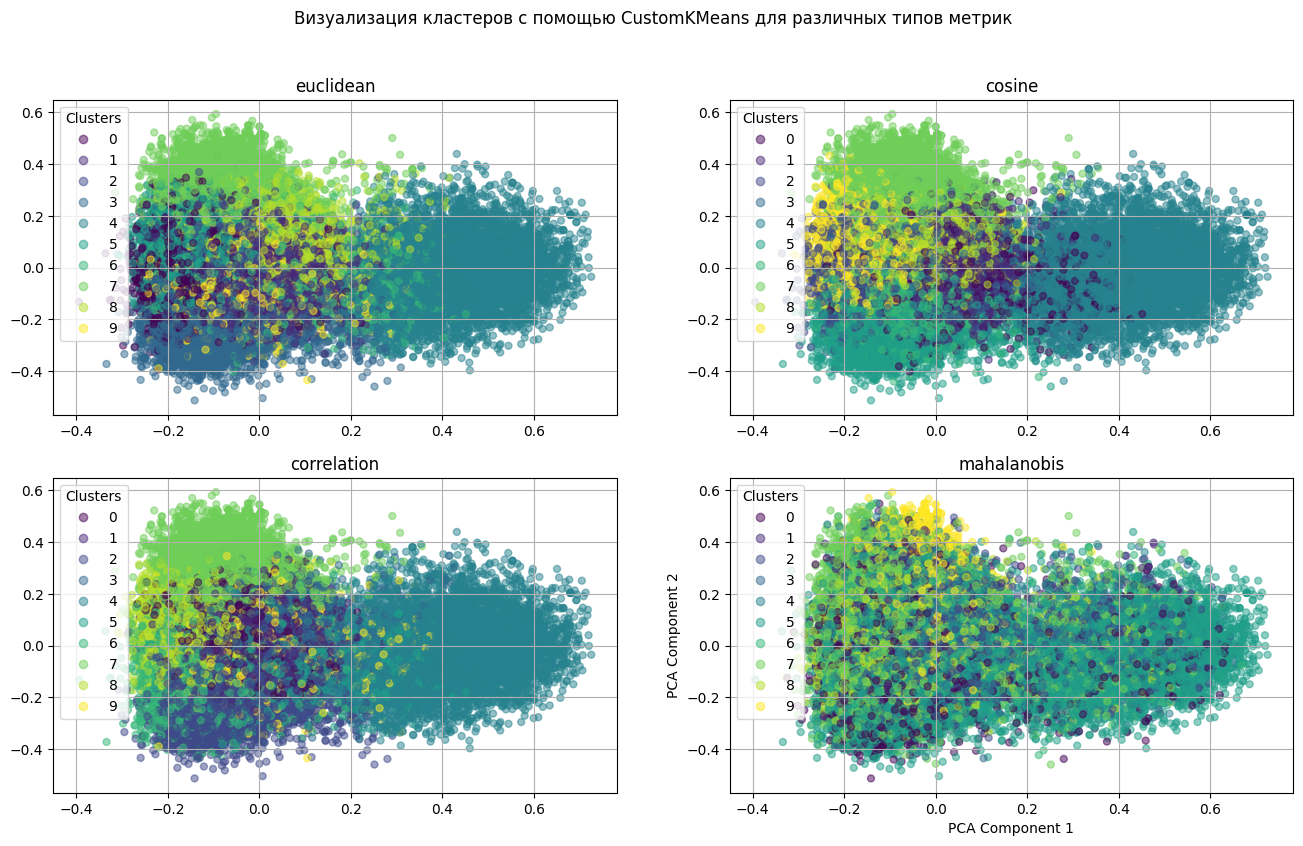

In [88]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

axes = axes.flatten()

for ax, dist_metric in zip(axes, distance_metrics):

    scatter = ax.scatter(reduced_embeddings[:, 0],
                         reduced_embeddings[:, 1],
                         c=labels_df[dist_metric],
                         cmap='viridis',
                         s=25,
                         alpha=0.5)
    ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.set_title(dist_metric)
    ax.grid(True)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

plt.suptitle("Визуализация кластеров с помощью CustomKMeans для различных типов метрик")
plt.show()

Let's print examples of the text for each cluster

In [89]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- It might be linked to the trust factor of your friend.
- When I feel down I listen to music.
- Oh forgive us for trying to make an exciting atmosphere at our homecourt.
- true I am a troll, but fortunately for me I'm not emotionally invested in it.
- People on the other side want you dead no matter why you are there.

Cluster 1:
- Fucking coward.
- Super, thanks
- Happy to be able to help.
- Very interesting. Thx
- Awesome. Thanks!

Cluster 2:
- Damn youtube and outrage drama is super lucrative for reddit
- Shit, I guess I accidentally bought a Pay-Per-View boxing match
- His name has already been released. Just can't post it here.
- Twilight... STILL a better love story than The Last Jedi!
- Detective from svu.

Cluster 3:
- To make her feel threatened
- Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol 
- Your aunt has some damn nerve, though!
- Should’ve dumped coke all over her right after the

## 6. Report

Make a conclusion and write a short report. What are the differnes between the methods used? What are their limitations? What is the applicability of each?

1. **Евклидово расстояние**

$$
d(a, b) = \sqrt{\sum\limits_{i} (a_i - b_i)^2}
$$

С помощью евклидова расстояния измеряется расстояние между двумя точками в евклидовом пространстве

**Плюсы:**
* Легко интерпретируется
* Быстро вычисляется

**Минусы:**
* Чувствительно к масштабу и выбросам

**Применение:** Подходит для данных с однородными и нормально распределенными признаками, где расстояние в пространстве можно интерпретировать напрямую

2. **Косинусное расстояние**

$$
d(a, b) = 1 - \frac{a \cdot b}{||a|| \cdot ||b||}
$$

С помощью косинусного расстояния измеряется угол между векторами

**Плюсы:**
* Легко интерпретируется
* Быстро вычисляется

**Минусы:**
* Не учитывает длину векторов

**Применение:** Косинусное расстояние подходит для задач обработки текстов, где важна не абсолютная величина признаков, а их соотношение

3. **Корреляционное расстояние**

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum\limits_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum\limits_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum\limits_{i=1}^{n}(b_i - \bar{b})^2}}
$$

Корреляционное расстояние измеряет степень линейной зависимости между двумя векторами

**Плюсы:**
* Устойчиво к масштабированию и сдвигам данных
* Выявляет линейные зависимости между признаками

**Минусы:**
* Может работать некорректно на нелинейных данных
* Чувствительно к выбросам

**Применение:** Подходит для данных, где важно выявить корреляции между переменными

4. **Расстояние Махаланобиса**

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

Расстояние Махаланобиса учитывает ковариацию признаков

**Плюсы:**
* Устойчиво к данным с разными масштабами и распределениями

**Минусы:**
* Требует расчета и обращения ковариационной матрицы, поэтому вычисление на больших датасетах занимает много времени
* Не работает на вырожденных ковариационных матрицах

**Применение:** Подходит для сложных данных с коррелированными признаками, где важно учитывать взаимосвязи между переменными

